# Modeling and Simulation in Python

Chapter 9: Projectiles

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Dropping pennies

I'll start by getting the units we'll need from Pint.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

And defining the initial state.

In [3]:
init = State(y=381 * m, 
             v=0 * m/s)
init

,value
y,381 meter
v,0.0 meter / second


Acceleration due to gravity is about 9.8 m / s$^2$.

In [4]:
g = 9.8 * m/s**2

When we call `odeint`, we need an array of timestamps where we want to compute the solution.

I'll start with a duration of 10 seconds.

In [17]:
duration = 10 * s
ts = linspace(0, duration, 21)
ts

<Quantity([  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10. ], 'second')>

Now we make a `System` object.

In [18]:
system = System(init=init, g=g, ts=ts)

And define the slope function.

In [40]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)    
    #print(t)
    dydt = v
    dvdt = -g
    
    return dydt, dvdt

It's always a good idea to test the slope function with the initial conditions.

In [20]:
dydt, dvdt = slope_func(init, 0, system)
print(dydt)
print(dvdt)

0
0.0 meter / second
-9.8 meter / second ** 2


Now we're ready to run `odeint`

In [21]:
run_odeint(system, slope_func)

0.0 second
0.0
1.2204606467739427e-05
1.2204606467739427e-05
2.4409212935478853e-05
2.4409212935478853e-05
0.12207047389032974
0.244116538567724
0.3661626032451183
1.586623250019061
2.8070838967930034
4.027544543566946
16.23215101130637


Here's what the results look like.

In [22]:
system.results.head()

,y,v
0.0,381.000,0.0
0.5,379.775,-4.9
1.0,376.100,-9.8
1.5,369.975,-14.7
2.0,361.400,-19.6


In [23]:
system.results.tail()

,y,v
8.0,67.400,-78.4
8.5,26.975,-83.3
9.0,-15.900,-88.2
9.5,-61.225,-93.1
10.0,-109.000,-98.0


The following function plots the results.

In [24]:
def plot_position(results):
    """Plot the results.
    
    results: DataFrame with position, `y`
    """
    newfig()
    plot(results.y, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

Here's what it looks like.

Saving figure to file chap09-fig01.pdf


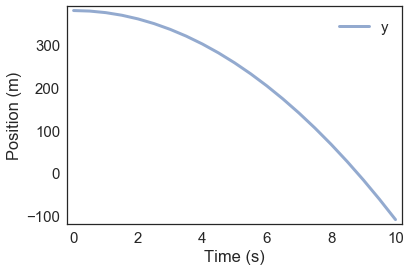

In [25]:
plot_position(system.results)
savefig('chap09-fig01.pdf')

**Exercise:** Add a print statement to `slope_func` to print the value of `t` each time it's called.  What can we infer about how `odeint` works, based on the results?

Odeint uses some kind of weird squaring thing, pretty confusing to be honest

**Exercise:** Change the value of `dt` and run the solver again.  What effect does it have on the results?

Doesn't appear to have much of an effect when you increase the dt

### Onto the sidewalk

Here's the code again to set up the `System` object.

In [26]:
def make_system(duration, v_init=0):
    """Make a system object.
    
    duration: time of simulation in seconds
    v_init: initial velocity, dimensionless
    
    returns: System object
    """
    init = State(y=381 * m, v=v_init * m / s)

    g = 9.8 * m/s**2
    ts = linspace(0, duration, 11)
    return System(init=init, g=g, ts=ts)

And run the simulation.

In [27]:
system = make_system(10)
run_odeint(system, slope_func)
system.results

0.0
0.0
1.2391823754412774e-05
1.2391823754412774e-05
2.478364750882555e-05
2.478364750882555e-05
0.12394302119163657
0.2478612587357643
0.37177949627989204
1.6109618717211696
2.850144247162447
4.089326622603725
16.481150377016498


,y,v
0.0,381.0,0.0
1.0,376.1,-9.8
2.0,361.4,-19.6
3.0,336.9,-29.4
4.0,302.6,-39.2
5.0,258.5,-49.0
6.0,204.6,-58.8
7.0,140.9,-68.6
8.0,67.4,-78.4
9.0,-15.9,-88.2


To figure out when the penny hit the sidewalk, we use `interp_inverse`, which return a function that maps from height to time.

In [28]:
y = system.results.y
T = interp_inverse(y, kind='cubic')

`T(0)` interpolates the time when the height was 0.

In [29]:
T_sidewalk = T(0)
T_sidewalk

array(8.81792826905006)

We can compare that to the exact result.  Without air resistance, we have

$v = -g t$

and

$y = 381 - g t^2 / 2$

Setting $y=0$ and solving for $t$ yields

$t = \sqrt{\frac{2 y_{init}}{g}}$

In [30]:
sqrt(2 * init.y / g)

<Quantity(8.817885349720552, 'second')>

The estimate is accurate to 4 decimal places.

We can double-check by running the simulation for the estimated flight time.

In [31]:
system = make_system(duration=T_sidewalk)
run_odeint(system, slope_func)

0.0
0.0
1.2373598314419205e-05
1.2373598314419205e-05
2.474719662883841e-05
2.474719662883841e-05
0.1237607303408209
0.24749671348501295
0.371232696629205
1.6085925280711255
2.845952359513046
4.083312190954967
16.45691050537417


And checking the final state.

In [32]:
def final_state(results):
    """Returns the final position and velocity, with units.
    
    results: TimeFrame with y and v.
    
    returns: y, v at t_end
    """
    t_end = results.index[-1]
    y, v = results.loc[t_end]
    return y*m, v*m/s

As expected, the final height is close to 0.

In [33]:
y_final, v_final = final_state(system.results)
y_final

<Quantity(-0.003708896250259386, 'meter')>

And we can check the final velocity.

In [34]:
v_final

<Quantity(-86.41569703669059, 'meter / second')>

And convert to km/h

In [35]:
km = UNITS.kilometer
h = UNITS.hour
v_final.to(km / h)

<Quantity(-311.0965093320861, 'kilometer / hour')>

If there were no air resistance, the penny would hit the sidewalk (or someone's head) at more than 300 km/h.

So it's a good thing there is air resistance.

**Exercise:** Try changing the initial velocity and see what effect it has on the time to hit the sidewalk.  Sweep a range of values for the initial velocity, from 0 to 25 m/s, and plot `T_sidewalk` as a function of initial velocity.  You might find the following function useful.

Things might go horribly wrong for the larger initial velocities.  What's going on?

It's messing up because the function is not monotonic.

In [41]:
linspace(0,25,26)
for i in linspace(0,25,26):
    system = make_system(10, v_init = i)
    run_odeint(system, slope_func)
    y = system.results.y
    T = interp_inverse(y, kind='cubic')
    T_sidewalk = T(0)
    print("T_sideWalk",T_sidewalk)

T_sideWalk 8.81792826905006
T_sideWalk 8.920517891741017
T_sideWalk 9.02434187963521
T_sideWalk 9.129592050149466
T_sideWalk 9.237372678794712
T_sideWalk 9.303838447717512
T_sideWalk 9.444442772983944
T_sideWalk 9.554526855369744
T_sideWalk 9.663930979401997
T_sideWalk 9.770241178162227
T_sideWalk 9.934325085755443
T_sideWalk 10.01013313357041
T_sideWalk 10.109514369134269
T_sideWalk 10.188078322154784
T_sideWalk 10.137119657846915
T_sideWalk 11.46427962935832
T_sideWalk 11.185014894830607
T_sideWalk 11.512490879441714
T_sideWalk 12.281208473788062
T_sideWalk 15.505046592359793
T_sideWalk 0.2727070965260341
T_sideWalk 4.445140197450866
T_sideWalk 2.7063857502291273
T_sideWalk -3.6863345003507413
T_sideWalk -39.580147612657
T_sideWalk 95.26958278497192


In [24]:
def flight_time(system):
    """Simulates the system and computes flight time.
    
    Uses cubic interpolation.
    
    system: System object
    
    returns: flight time in seconds
    """
    run_odeint(system, slope_func)
    y = system.results.y
    inverse = Series(y.index, index=y.values)
    T = interpolate(inverse, kind='cubic')
    T_sidewalk = T(0)
    return T_sidewalk * s

In [44]:
# Solution goes here
def Whoops(I_Messed_Up_Dot_JPG):
    print (I_Messed_Up_Dot_JPG)
When_You_Mess_Up = "I didn't see that the function was already made, my bad"
Whoops(When_You_Mess_Up)

I didn't see that the function was already made, my bad


### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

First I'll create a `Condition` object to contain the quantities we'll need.

In [45]:
condition = Condition(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 2.5e-3 * kg,
                      diameter = 19e-3 * m,
                      rho = 1.2 * kg/m**3,
                      v_term = 18 * m / s,
                      duration = 30 * s)

Now here's a version of `make_system` that takes a `Condition` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [46]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, g, mass, diameter, 
               rho, v_term, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, ts=ts)

Let's make a `System`

In [47]:
system = make_system(condition)
system

,value
init,y 381 meter v 0.0 meter / secon...
g,9.8 meter / second ** 2
mass,0.0025 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.4445009981135434 dimensionless
area,0.0002835287369864788 meter ** 2
ts,"[0.0 second, 0.3 second, 0.6 second, 0.8999999..."


Here's the slope function, including acceleration due to gravity and drag.

In [48]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [49]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

And then run the simulation.

In [50]:
run_odeint(system, slope_func)

First check that the simulation ran long enough for the penny to land.

In [51]:
final_state(system.results)

(<Quantity(-136.083704279796, 'meter')>,
 <Quantity(-18.00000000087864, 'meter / second')>)

Then compute the flight time.

In [52]:
y = system.results.y
inverse = Series(y.index, index=y.values)
T = interpolate(inverse, kind='cubic')
T_sidewalk = T(0)
T_sidewalk

array(22.439794207078908)

Setting the duration to the computed flight time, we can check the final conditions.

In [53]:
condition.set(duration=T_sidewalk)
system = make_system(condition)
run_odeint(system, slope_func)
y_final, v_final = final_state(system.results)

The final height is close to 0, as expected.  And the final velocity is close to the given terminal velocity.

In [54]:
y_final, v_final

(<Quantity(1.2732392917769175e-10, 'meter')>,
 <Quantity(-18.00000000874157, 'meter / second')>)

Here's the plot of position as a function of time.

Saving figure to file chap09-fig02.pdf


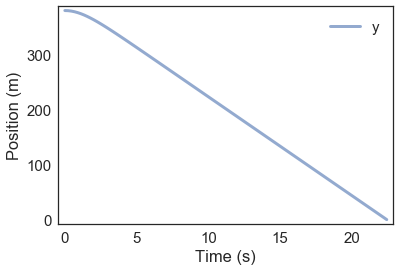

In [55]:
plot_position(system.results)
savefig('chap09-fig02.pdf')

And velocity as a function of time:

In [56]:
def plot_velocity(results):
    """Plot the results.
    
    results: DataFrame with velocity, v
    """
    newfig()
    plot(results.v, label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/2)')

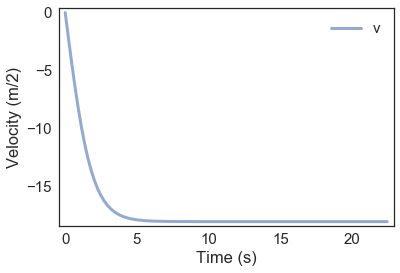

In [57]:
plot_velocity(system.results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: use `condition.set`.

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

I expect the velocity to decrease to the terminal velocity shortly afterwards

In [60]:
# Solution goes here
condition.set(v_init = -100 * m / s) # Firing the coin out of a cannon

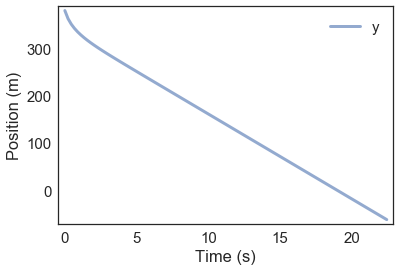

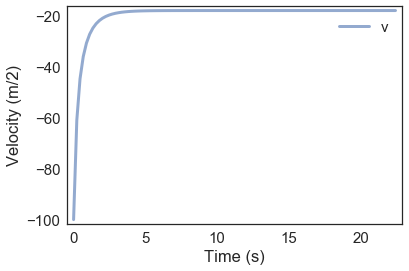

In [62]:
# Solution goes here
system = make_system(condition)
run_odeint(system, slope_func)
plot_position(system.results)
plot_velocity(system.results)

### Dropping quarters

Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  We can use this measurement to estimate the coefficient of drag.

Here's a `Condition` object with the relevant parameters from
https://en.wikipedia.org/wiki/Quarter_(United_States_coin)


In [63]:
condition = Condition(height = 381 * m,
                      v_init = 0 * m / s,
                      g = 9.8 * m/s**2,
                      mass = 5.67e-3 * kg,
                      diameter = 24.26e-3 * m,
                      rho = 1.2 * kg/m**3,
                      duration = 19.1 * s)

And here's a modified version of `make_system`

In [64]:
def make_system(condition):
    """Makes a System object for the given conditions.
    
    condition: Condition with height, v_init, g, mass, diameter, 
               rho, C_d, and duration
    
    returns: System with init, g, mass, rho, C_d, area, and ts
    """
    unpack(condition)
    
    init = State(y=height, v=v_init)
    area = np.pi * (diameter/2)**2
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, rho=rho,
                  C_d=C_d, area=area, ts=ts)

We can run the simulation with an initial guess of `C_d=0.4`.

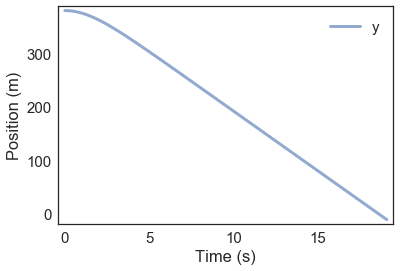

In [65]:
condition.set(C_d=0.4)
system = make_system(condition)
run_odeint(system, slope_func)
plot_position(system.results)

The final height is -11 meters, which means our guess was too low (we need more drag to slow the quarter down).

In [66]:
final_state(system.results)

(<Quantity(-11.034779626277231, 'meter')>,
 <Quantity(-22.380158694375393, 'meter / second')>)

`height_func` takes a hypothetical value of `C_d` and returns the height after 19.1 seconds.

In [67]:
def height_func(C_d, condition):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    condition: Condition object
    
    returns: height in m
    """
    condition.set(C_d=C_d)
    system = make_system(condition)
    run_odeint(system, slope_func)
    y, v = final_state(system.results)
    return y

If we run it with `C_d=0.4`, we get -11 meters again.

In [68]:
height_func(0.4, condition)

<Quantity(-11.034779626277231, 'meter')>

Now we can use `fsolve` to find the value of `C_d` that makes the final height 0.

In [69]:
solution = fsolve(height_func, 0.4, condition)
solution

array([ 0.42587017])

Plugging in the estimated value, we can run the simulation again to get terminal velocity.

In [70]:
condition.set(C_d=solution)
system = make_system(condition)
run_odeint(system, slope_func)
final_state(system.results)

(<Quantity(-4.725109192804666e-13, 'meter')>,
 <Quantity(-21.689751051700213, 'meter / second')>)

In this example, the terminal velocity of the quarter is higher than that of the penny, but we should not take this result seriously because the measurements we used are not real; I made them up.